In [227]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.basemap import Basemap


In [228]:
ais = pd.read_csv('data/datasets/ais_train.csv', sep='|')
ais['time'] = pd.to_datetime(ais['time'])
ais.head()

vessels = pd.read_csv('data/datasets/vessels.csv', sep='|')
vessels.head()

ports = pd.read_csv('data/datasets/ports.csv', sep='|')
ports.head()

,portId,name,portLocation,longitude,latitude,UN_LOCODE,countryName,ISO
0,61d36ed80a1807568ff9a064,Port of Algiers,Algiers,3.067222,36.773611,DZALG,Algeria,DZ
1,61d36ed80a1807568ff9a065,Port of Annaba,Annaba,7.772500,36.900556,DZAAE,Algeria,DZ
2,61d36edf0a1807568ff9a070,Port of Oran,Oran,-0.639722,35.712222,DZORN,Algeria,DZ
3,61d36ee00a1807568ff9a072,Port of Skikda,Skikda,6.905833,36.887500,DZSKI,Algeria,DZ
4,61d36ee10a1807568ff9a074,Port of Pago-Pago,Pago-Pago,-170.690556,-14.274167,ASPPG,American Samoa,AS


In [229]:
ais.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


In [230]:
vessels.head()

,shippingLineId,vesselId,CEU,DWT,GT,NT,vesselType,breadth,depth,draft,enginePower,freshWater,fuel,homePort,length,maxHeight,maxSpeed,maxWidth,rampCapacity,yearBuilt
0,61a8e672f9cba188601e84ab,61e9f38eb937134a3c4bfd8b,6500,21200.0,58684,17606.0,83.0,32.0,22.20,NaN,0.0,NaN,NaN,OSLO,199.00,5.0,18.6,15.2,150.0,2000
1,61ec94f1a8cafc0e93f0e92a,61e9f38eb937134a3c4bfd8d,4902,12325.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,MONROVIA,182.00,NaN,NaN,NaN,NaN,2006
2,61e213d5d612676a0f0fb755,61e9f38eb937134a3c4bfd8f,5000,13059.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,SAINT JOHN'S,182.00,NaN,NaN,NaN,NaN,2010
3,61be24574ea00ae59d0fe388,61e9f38eb937134a3c4bfd91,4200,12588.0,39362,NaN,83.0,28.0,NaN,NaN,11060.0,NaN,NaN,NaN,167.00,NaN,NaN,NaN,NaN,2011
4,61a8e673f9cba188601e84ae,61e9f390b937134a3c4bfd93,7450,21052.0,75528,24391.0,83.0,37.2,22.23,NaN,13140.0,491.47,3236.78,Panama,199.98,NaN,NaN,NaN,NaN,2018


In [231]:
port_id_mapping = {port_id: idx for idx, port_id in enumerate(ais['portId'].unique())}
ais['portId'] =ais['portId'].map(port_id_mapping)
ports['portId'] = ports['portId'].map(port_id_mapping)

vessel_id_mapping = {vessel_id: idx for idx, vessel_id in enumerate(ais['vesselId'].unique())}
ais['vesselId'] =ais['vesselId'].map(vessel_id_mapping)
vessels['vesselId'] = vessels['vesselId'].map(vessel_id_mapping)


shipping_line_id_mapping = {shipping_line_id: idx for idx, shipping_line_id in enumerate(vessels['shippingLineId'].unique())}
vessels['shippingLineId'] = vessels['shippingLineId'].map(shipping_line_id_mapping)

In [232]:
print(ais.info())
nan_values = ais.isna().sum()
print(nan_values)
missing_values_count = ais.isnull().sum()
print(missing_values_count)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   time       1522065 non-null  datetime64[ns]
 1   cog        1522065 non-null  float64       
 2   sog        1522065 non-null  float64       
 3   rot        1522065 non-null  int64         
 4   heading    1522065 non-null  int64         
 5   navstat    1522065 non-null  int64         
 6   etaRaw     1522065 non-null  object        
 7   latitude   1522065 non-null  float64       
 8   longitude  1522065 non-null  float64       
 9   vesselId   1522065 non-null  int64         
 10  portId     1522065 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 127.7+ MB
None
time         0
cog          0
sog          0
rot          0
heading      0
navstat      0
etaRaw       0
latitude     0
longitude    0
vesselId     0
portId      

Several data_points does not have port_id!

##### Check values that are missing/default in the dataset

Some values are marked as missing by using specific values like 360 for COG and 1023 for SOG, and ROT

COG - Course over Ground, relative to the north vector 
* 360 = not available = default. 
* 360.1 - 409.5 should not be used 

SOG - Speed over Ground 
* Speed over ground in 1/10 knot steps (0-102.2 knots)
* 1 023 = not available, 1 022 = 102.2 knots or higher

Rate of Turn 
* 0 to +126 = turning right at up to 708 deg per min or higher
* 0 to -126 = turning left at up to 708 deg per min or higher Values between 0 and 708
* +127 = turning right at more than 5 deg per 30 s (No TI available), when the ship is turning fast there is no turn indicator available 
* -127 = turning left at more than 5 deg per 30 s (No TI available)
* -128 (80 hex) indicates no turn information available (default).

Heading 
- Degrees (0-359) (511 indicates not available = default)

Picture of AIS system

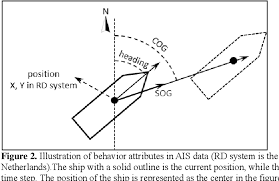

In [233]:
initial_count = ais.shape[0]
ais.drop_duplicates(inplace=True)
ais.head()
dropped_count = initial_count - ais.shape[0]
print(f"Number of rows dropped: {dropped_count}")

Number of rows dropped: 0


In [234]:
ais['cog'] = ais['cog'].apply(lambda x: np.nan if 360 <= x <= 409.5 else x)

# Replace 1023 and values over 102.2 in SOG with NaN
ais['sog'] = ais['sog'].replace([1023, np.nan])

# Replace other variables similarly
# For ROT, replace -128 (no turn info) with NaN
ais['rot'] = ais['rot'].replace([-128], np.nan)

# For heading, replace 511 (no heading info) with NaN
ais['heading'] = ais['heading'].replace([511], np.nan)

C:\Users\ingvi\AppData\Local\Temp\ipykernel_12784\1530790075.py:4: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  ais['sog'] = ais['sog'].replace([1023, np.nan])


In [235]:

print(ais['cog'].describe())
print(ais[['cog', 'sog', 'rot', 'heading', 'latitude', 'longitude']].isna().sum())
print(len(ais))


count    1.516207e+06
mean     1.775472e+02
std      1.072909e+02
min      0.000000e+00
25%      7.800000e+01
50%      1.830000e+02
75%      2.680000e+02
max      3.599000e+02
Name: cog, dtype: float64
cog          5858
sog             0
rot             0
heading      4895
latitude        0
longitude       0
dtype: int64
1522065


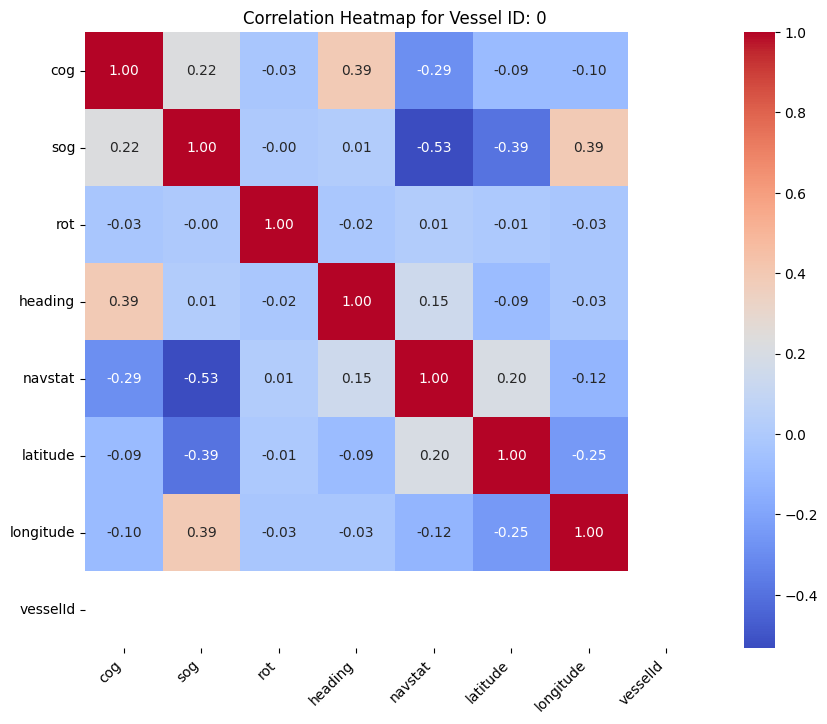

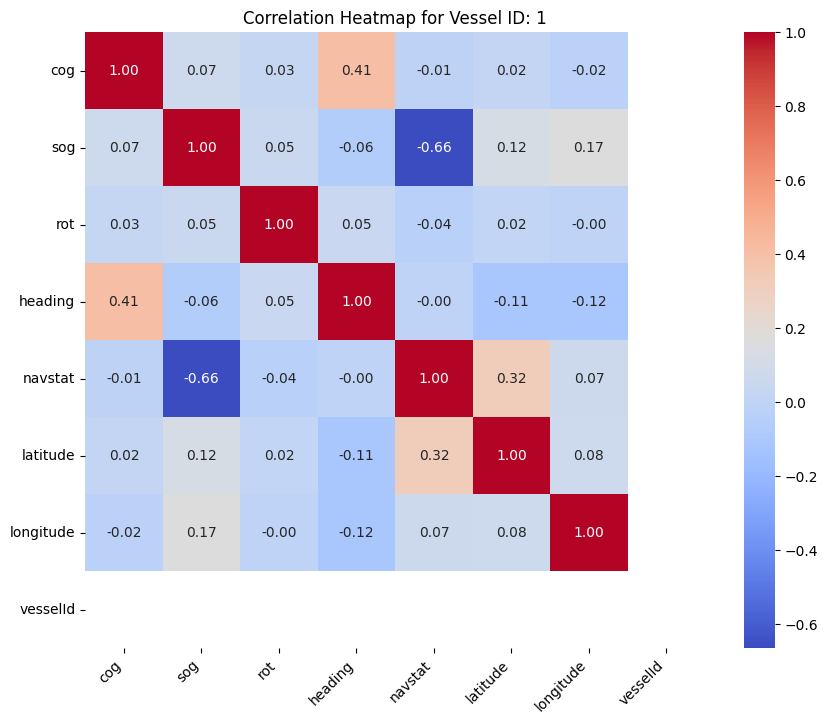

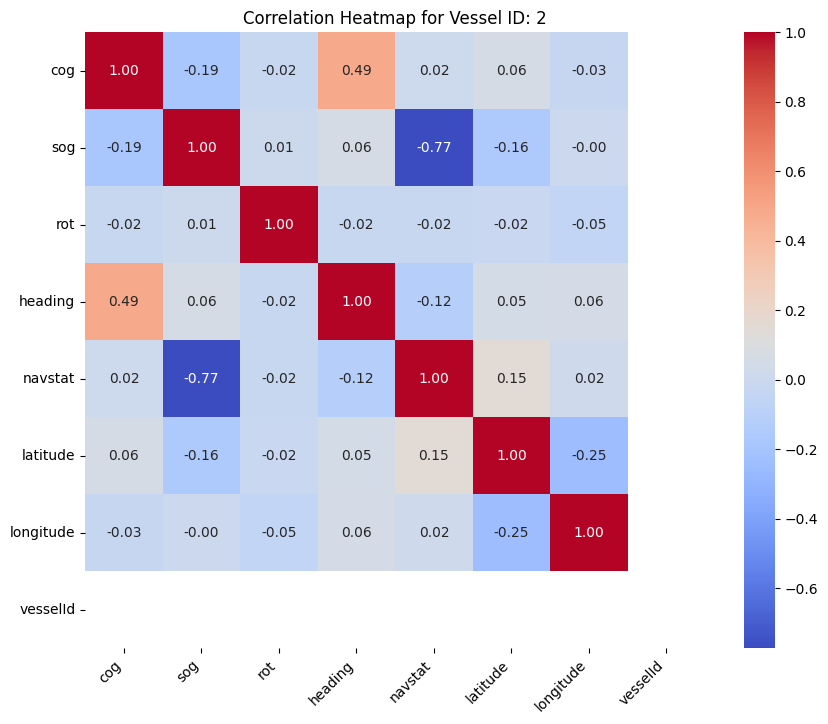

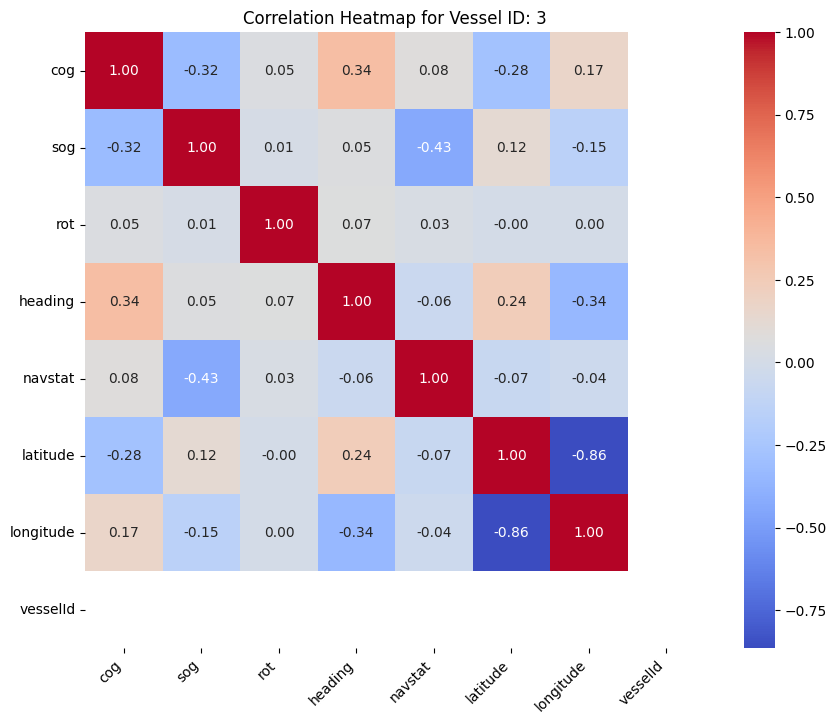

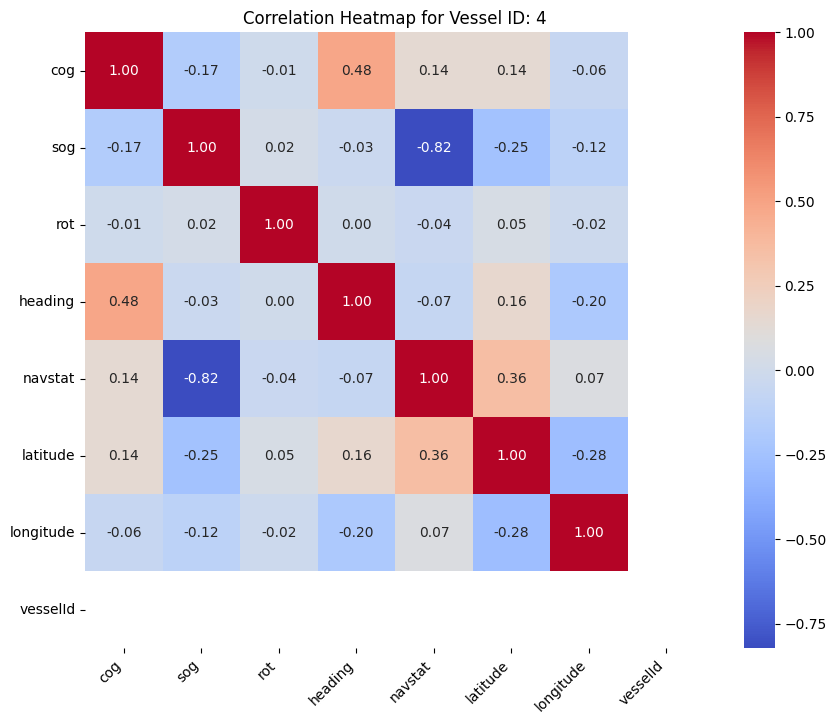

In [236]:
ais_filtered = ais.drop(columns=['time', 'etaRaw', 'portId'])

grouped = ais_filtered.groupby('vesselId')
five_vessels = list(itertools.islice(grouped, 5))

for vessel_id, group in five_vessels:
    numeric_group = group.select_dtypes(include=[float, int])

    correlation_matrix = numeric_group.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Heatmap for Vessel ID: {vessel_id}')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

Given by the correlation matrix one can see that there are no features that correlate strongly. 

In [237]:
def detect_outliers(series, window_size=6, threshold=2):
    rolling_median = series.rolling(window=window_size, center=True).median()
    rolling_std = series.rolling(window=window_size, center=True).std()
    outliers = (series - rolling_median).abs() > (threshold * rolling_std)
    return outliers

outliers_dict = {}
for vessel_id, group in ais.groupby('vesselId'):
    outliers_dict[vessel_id] = {}
    for column in ['cog', 'sog', 'rot', 'heading']:
        outliers_dict[vessel_id][column] = detect_outliers(group[column])

vessels_with_outliers = {}
for vessel_id, columns in outliers_dict.items():
    for column, outliers in columns.items():
        if outliers.any():
            if vessel_id not in vessels_with_outliers:
                vessels_with_outliers[vessel_id] = []
            vessels_with_outliers[vessel_id].append(column)

print("Vessel IDs with outliers and the corresponding columns:")
for vessel_id, columns in vessels_with_outliers.items():
    print(f"Vessel ID: {vessel_id}, Columns: {columns}")

Vessel IDs with outliers and the corresponding columns:
Vessel ID: 0, Columns: ['cog', 'sog', 'rot', 'heading']
Vessel ID: 1, Columns: ['cog', 'sog', 'rot', 'heading']
Vessel ID: 2, Columns: ['cog', 'sog', 'rot', 'heading']
Vessel ID: 3, Columns: ['cog', 'sog', 'rot', 'heading']
Vessel ID: 4, Columns: ['cog', 'sog', 'rot', 'heading']
Vessel ID: 5, Columns: ['cog', 'sog', 'rot', 'heading']
Vessel ID: 6, Columns: ['cog', 'sog', 'rot', 'heading']
Vessel ID: 7, Columns: ['cog', 'sog', 'rot', 'heading']
Vessel ID: 8, Columns: ['cog', 'sog', 'rot', 'heading']
Vessel ID: 9, Columns: ['cog', 'sog', 'rot', 'heading']
Vessel ID: 10, Columns: ['cog', 'sog', 'rot', 'heading']
Vessel ID: 11, Columns: ['cog', 'sog', 'rot', 'heading']
Vessel ID: 12, Columns: ['cog', 'sog', 'rot', 'heading']
Vessel ID: 13, Columns: ['cog', 'sog', 'rot', 'heading']
Vessel ID: 14, Columns: ['cog', 'sog', 'rot', 'heading']
Vessel ID: 15, Columns: ['cog', 'sog', 'rot', 'heading']
Vessel ID: 16, Columns: ['cog', 'sog', 'ro

C:\Users\ingvi\AppData\Local\Temp\ipykernel_12784\3156589378.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_vessel_ids))
c:\Users\ingvi\ml\.venv\Lib\site-packages\pyproj\transformer.py:820: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return self._transformer._transform_point(


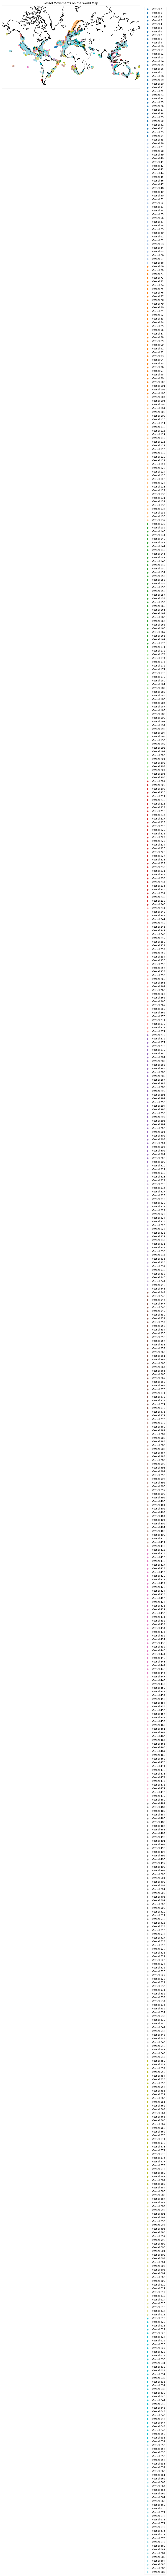

In [238]:
plt.figure(figsize=(10,7))
m = Basemap(projection='merc',llcrnrlat=-60,urcrnrlat=80,llcrnrlon=-180,urcrnrlon=180)
m.drawcoastlines()

# Scatter plot for vessel locations

# Extract unique vessel IDs
unique_vessel_ids = ais['vesselId'].unique()

# Create a color map for vessels
colors = plt.cm.get_cmap('tab20', len(unique_vessel_ids))

# Plot each vessel with a different color
for idx, vessel_id in enumerate(unique_vessel_ids):
    vessel_data = ais[ais['vesselId'] == vessel_id]
    m.scatter(vessel_data['longitude'], vessel_data['latitude'], latlon=True, 
              color=colors(idx), label=f'Vessel {vessel_id}', marker='o')

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Vessel Movements on the World Map')
plt.show()

In [239]:
ais = ais.merge(ports[['portId', 'latitude', 'longitude']], how='left', left_on='portId', right_on='portId', suffixes=('', '_port'))
ais.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port
0,2024-01-01 00:00:25,284.0,0.7,0,88.0,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889
1,2024-01-01 00:00:36,109.6,0.0,-6,347.0,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000
2,2024-01-01 00:01:45,111.0,11.0,0,112.0,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889
3,2024-01-01 00:03:11,96.4,0.0,0,142.0,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444
4,2024-01-01 00:03:51,214.0,19.7,0,215.0,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000


In [240]:
missing_values_vessels = vessels.isna().sum()
print(missing_values_vessels)

shippingLineId      0
vesselId           23
CEU                 0
DWT                 8
GT                  0
NT                524
vesselType         12
breadth             8
depth             469
draft             701
enginePower        20
freshWater        490
fuel              490
homePort          138
length              0
maxHeight         676
maxSpeed          498
maxWidth          676
rampCapacity      677
yearBuilt           0
dtype: int64


In [241]:
# Select only the specified columns from the vessels DataFrame
vessels_subset = vessels[['vesselId', 'vesselType', 'length', 'homePort', 'shippingLineId']]

# Merge the ais DataFrame with the vessels_subset DataFrame on the vesselId column
ais_merged = ais.merge(vessels_subset, on='vesselId', how='left')

# Display the first few rows of the merged DataFrame
ais_merged.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port,vesselType,length,homePort,shippingLineId
0,2024-01-01 00:00:25,284.0,0.7,0,88.0,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889,83.0,199.00,NASSAU,9
1,2024-01-01 00:00:36,109.6,0.0,-6,347.0,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000,83.0,199.97,Monrovia,6
2,2024-01-01 00:01:45,111.0,11.0,0,112.0,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889,83.0,199.00,NaN,14
3,2024-01-01 00:03:11,96.4,0.0,0,142.0,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444,83.0,199.00,NaN,5
4,2024-01-01 00:03:51,214.0,19.7,0,215.0,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000,83.0,199.95,Panama,6


[ 9  6 14  5 11  7 10  0 23 19  2 21  8 17  4 16  1  3 24 12 15 13 26 20
 25 18 22]


C:\Users\ingvi\AppData\Local\Temp\ipykernel_12784\46211366.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_shipping_line_ids))


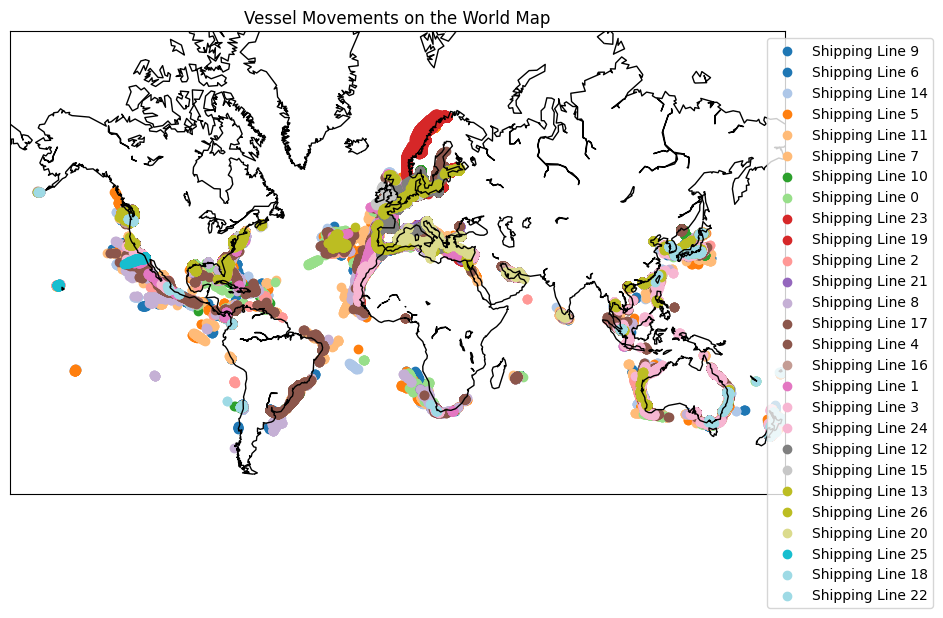

In [242]:
plt.figure(figsize=(10,7))
m = Basemap(projection='merc',llcrnrlat=-60,urcrnrlat=80,llcrnrlon=-180,urcrnrlon=180)
m.drawcoastlines()

# Scatter plot for vessel locations
# Extract unique shipping line IDs
unique_shipping_line_ids = ais_merged['shippingLineId'].unique()
print(unique_shipping_line_ids)

# Create a color map for shipping lines
colors = plt.cm.get_cmap('tab20', len(unique_shipping_line_ids))

# Plot each shipping line with a different color
for idx, shipping_line_id in enumerate(unique_shipping_line_ids):
    shipping_line_data = ais_merged[ais_merged['shippingLineId'] == shipping_line_id]
    m.scatter(shipping_line_data['longitude'], shipping_line_data['latitude'], latlon=True, 
              color=colors(idx), label=f'Shipping Line {shipping_line_id}', marker='o')
# Extract unique vessel IDs
unique_vessel_ids = ais_merged['vesselId'].unique()

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Vessel Movements on the World Map')
plt.show()

In [243]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of Earth in kilometers (6371 km)
    km = 6371 * c
    return km

In [245]:

# # Group by vesselId and calculate total distance traveled for each vessel
# total_distances = ais_merged.groupby('vesselId')['distance'].sum().reset_index()
# total_distances.head()

# ais_merged['tot_distance'] = ais_merged['vesselId'].map(total_distances.set_index('vesselId')['distance'])
# ais_merged.head()

In [247]:
ais_merged['vessel_type'] = np.where(ais_merged['length'] > 200, 'deep-sea', 'short-sea')
ais_merged.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port,vesselType,length,homePort,shippingLineId,vessel_type
0,2024-01-01 00:00:25,284.0,0.7,0,88.0,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889,83.0,199.00,NASSAU,9,short-sea
1,2024-01-01 00:00:36,109.6,0.0,-6,347.0,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000,83.0,199.97,Monrovia,6,short-sea
2,2024-01-01 00:01:45,111.0,11.0,0,112.0,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889,83.0,199.00,NaN,14,short-sea
3,2024-01-01 00:03:11,96.4,0.0,0,142.0,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444,83.0,199.00,NaN,5,short-sea
4,2024-01-01 00:03:51,214.0,19.7,0,215.0,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000,83.0,199.95,Panama,6,short-sea


In [248]:
# Group by vessel type and port ID to see which types of vessels visit which ports
vessel_port_visits = ais_merged.groupby(['vessel_type', 'portId']).size().reset_index(name='visit_count')

# Sort the results for better readability
vessel_port_visits = vessel_port_visits.sort_values(by=['vessel_type', 'visit_count'], ascending=[True, False])

deep_sea_visits = vessel_port_visits[vessel_port_visits['vessel_type'] == 'deep-sea']

# Display the deep-sea vessel visits to ports
print(deep_sea_visits)
unique_ports_count = deep_sea_visits['portId'].nunique()
print(f"Number of unique ports visited by deep-sea vessels: {unique_ports_count}")
unique_ports_count = vessel_port_visits['portId'].nunique()
print(f"Number of unique ports visited by all vessels: {unique_ports_count}")
short_sea_visits = vessel_port_visits[vessel_port_visits['vessel_type'] == 'short-sea']
unique_ports_count_short_sea = short_sea_visits['portId'].nunique()
print(f"Number of unique ports visited by short-sea vessels: {unique_ports_count_short_sea}")

# Find ports visited only by deep-sea vessels
deep_sea_ports = set(deep_sea_visits['portId'])
short_sea_ports = set(short_sea_visits['portId'])

# Ports visited only by deep-sea vessels
only_deep_sea_ports = deep_sea_ports - short_sea_ports
print(f"Ports visited only by deep-sea vessels: {only_deep_sea_ports}")

# Ports visited only by short-sea vessels
only_short_sea_ports = short_sea_ports - deep_sea_ports
print(f"Ports visited only by short-sea vessels: {only_short_sea_ports}")

    vessel_type  portId  visit_count
39     deep-sea      40        18726
13     deep-sea      14        16172
48     deep-sea      49        13071
2      deep-sea       2        11026
38     deep-sea      39         9313
..          ...     ...          ...
459    deep-sea     603            1
467    deep-sea     635            1
481    deep-sea     692            1
495    deep-sea     722            1
500    deep-sea     746            1

[510 rows x 3 columns]
Number of unique ports visited by deep-sea vessels: 510
Number of unique ports visited by all vessels: 773
Number of unique ports visited by short-sea vessels: 747
Ports visited only by deep-sea vessels: {264, 533, 536, 539, 674, 559, 695, 696, 697, 702, 705, 706, 707, 710, 87, 739, 742, 754, 629, 630, 757, 633, 762, 635, 764, 763}
Ports visited only by short-sea vessels: {517, 7, 530, 531, 532, 534, 537, 541, 542, 545, 547, 549, 553, 554, 556, 557, 558, 560, 562, 51, 52, 563, 564, 565, 566, 568, 569, 570, 571, 572, 577, 579, 

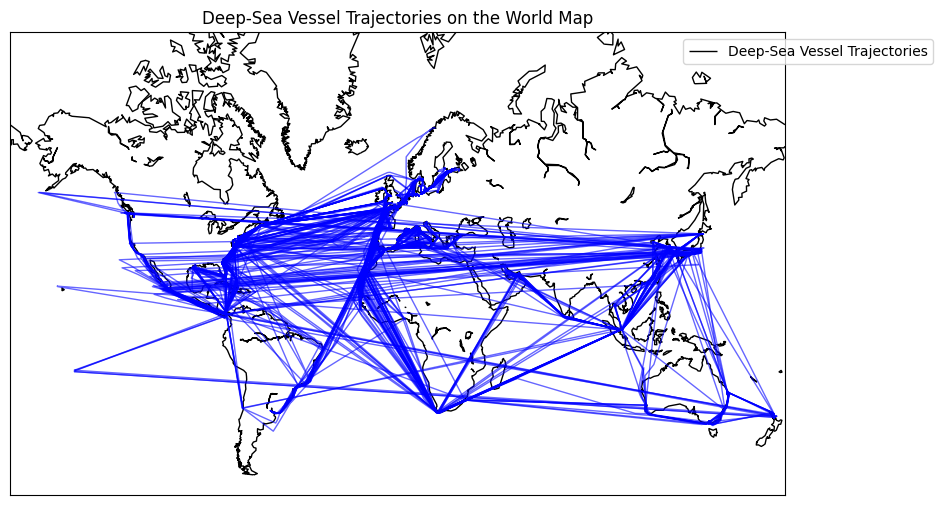

In [249]:

plt.figure(figsize=(10, 7))
m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180)
m.drawcoastlines()

# Set different colors for deep-sea and short-sea vessels
colors = {'deep-sea': 'blue', 'short-sea': 'green'}

# Plot deep-sea vessel trajectories
deep_sea_data = ais_merged[ais_merged['vessel_type'] == 'deep-sea']

# Group by vesselId to plot trajectories for each vessel
for vessel_id, vessel_data in deep_sea_data.groupby('vesselId'):
    # Get longitude and latitude data
    lon = vessel_data['longitude'].values
    lat = vessel_data['latitude'].values
    
    # Convert lat/lon to map coordinates
    x, y = m(lon, lat)
    
    # Plot the trajectory as a line
    m.plot(x, y, marker=None, color=colors['deep-sea'], linewidth=1, alpha=0.6)

# Add legend
plt.legend(['Deep-Sea Vessel Trajectories'], loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Deep-Sea Vessel Trajectories on the World Map')

plt.show()

In [261]:
ais_merged = ais_merged.sort_values(by=['vesselId', 'time'])

ais_merged['port_change'] = ais_merged.groupby('vesselId')['portId'].shift() != ais_merged['portId']

# Create a new column to count visits
ais_merged['visit'] = ais_merged['port_change'].cumsum()  # Cumulative sum to create a unique visit identifier
port_visits = ais_merged.groupby(['vesselId', 'portId', 'visit']).size().reset_index(name='visit_count')

# Display the first few rows of the grouped data
port_visits

,vesselId,portId,visit,visit_count
0,0,0,1,35
1,0,28,12,10
2,0,28,16,10
3,0,37,36,1
4,0,44,57,60
...,...,...,...,...
63576,687,384,63579,8
63577,687,391,63560,2
63578,687,733,63574,1
63579,687,749,63580,10


In [ ]:
# Plotting visits to ports by vessels
heatmap_data = port_visits.pivot_table(index='portId', columns='vesselId', values='visit_count', fill_value=0)

# Create a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt="d", linewidths=.5)

# Adding titles and labels
plt.title('Heatmap of Visits to Ports by Vessels')
plt.xlabel('Vessel ID')
plt.ylabel('Port ID')
plt.tight_layout()  # Adjust layout
plt.show()

KeyboardInterrupt: 